In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import skimage.io as io
from skimage.transform import resize, rescale, rotate

import os
import sys
sys.path.append('/classifier')
import src.preprocess as pp # Custom functions

# 1) Data quality check

First we want to check the number of images and their file extensions. In each folder there are 1000 jpg images. Let's assume that these images are all encoded as jpgs are not corrupt in any way.

In [2]:
# Check number of files and data extensions
for files in ('donuts', 'ceviche'):
    file_exts = [str.split(ext, sep = '.')[1] for ext in os.listdir(f'../data/{files}/')]
    print(f'{files}: ', pd.DataFrame({'extensions':file_exts})['extensions'].value_counts(), '\n')
    

donuts:  jpg    1000
Name: extensions, dtype: int64 

ceviche:  jpg    1000
Name: extensions, dtype: int64 



### Visualise files

Next, let's take a look at a subset of images in both data directories.

In [3]:
# Load data into separate objects
ceviche = io.ImageCollection('../data/ceviche/*.jpg')
donuts = io.ImageCollection('../data/donuts/*.jpg')

# Create index to sample 20 random images
np.random.seed(40)
random_idx = np.random.randint(1000, size=20)

def plot_img_grid(food):
    '''
    Creates 4x5 grid of image files
    '''
    
    fig, axes = plt.subplots(4, 5, figsize=(10, 10))
    ax = axes.ravel()
    
    for i in range(20):
        ax[i].imshow(food[random_idx[i]], cmap="gray")
        ax[i].axis('off')
    fig.tight_layout()
    plt.show()

/usr/local/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


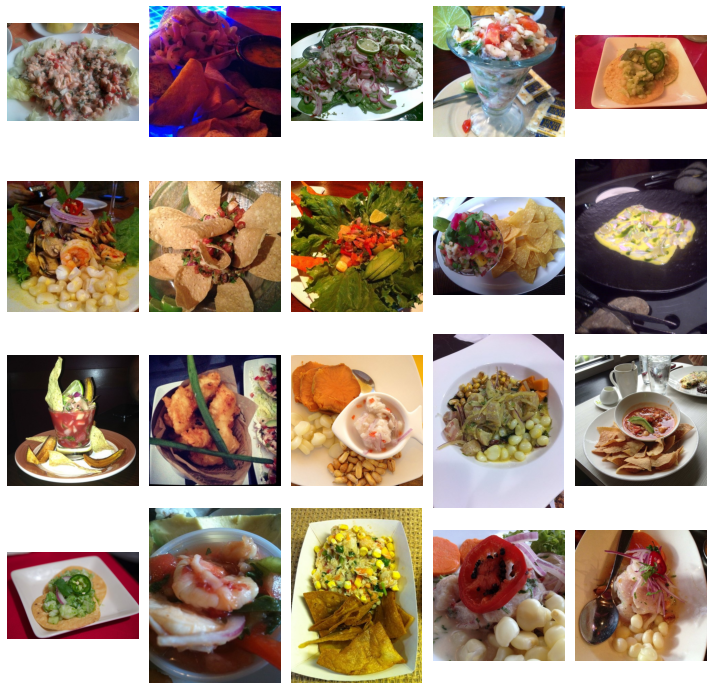

In [4]:
# Plot Ceviche
plot_img_grid(food = ceviche)

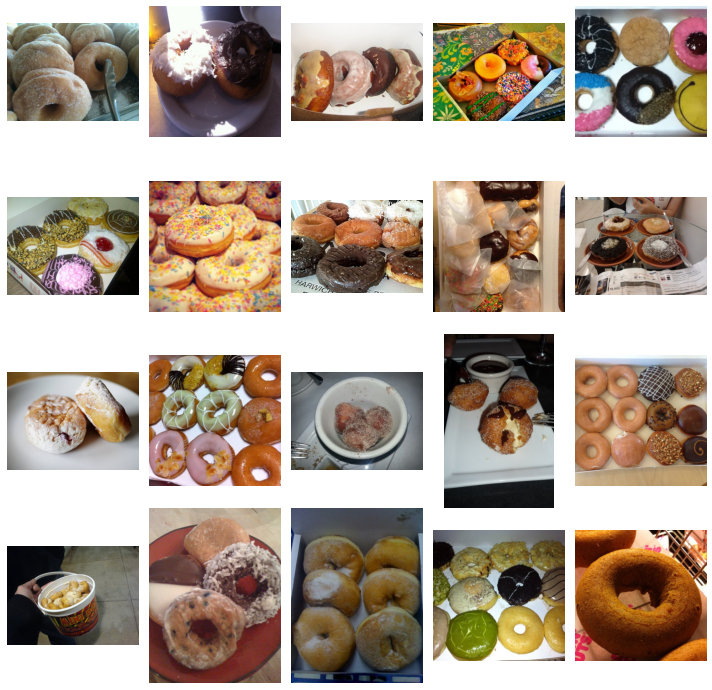

In [5]:
# Plot Donuts
plot_img_grid(food = donuts)

A few details can be observed:

1) Images have different dimensions
2) Images are in colour
3) There are different shadings (some bright, some dark) and have other random features (plates, boxes, backgrounds)
4) Image quality varies, some have clearer resolution than others
5) Heterogeneity in the types of food within each group (e.g. some donuts are round with holes in them, some are round balls)
    
This has implications for how one might approach feature preprocessing/engineering. Before we move onto that, let's make assume the **directories holding the images are correctly labelled.** So all images in the donut directory are actually all donuts and all images in ceviche directory are ceviches. I've only visually inspected a small subset of images which I can confirm are correctly labelled, so for simplicity I will make the assumption for all images in the folders.

# 2) Data preprocessing

Our raw data sample size is 2000, evenly split between two types of food. The pixels of can image can be used as features for classification. E.g. a 50x50 image contains 2500 pixels which could be modelled as 2500 features. Adding colour as a dimension (RGB) multiplies this by 3 to 7500 potential features. Since 7500 is much larger than our available sample size, modeling raw, coloured pixels like this will lead to overfitting (the curse of dimensionality strikes again!).

Therefore, we need to apply some dimensionality reduction techniques. I will approach this by:

1) Loading images in grey scale 

2) Resize the images so they are the same dimension

## 1. Grey scale
Loading in data in grey scale greatly simplifies the analysis by removing the colour dimension of the feature space (RGB). 

In [6]:
# Read in data in grey scale
ceviche_g = io.ImageCollection('../data/ceviche/*.jpg', as_gray = True)
donuts_g = io.ImageCollection('../data/donuts/*.jpg', as_gray = True)

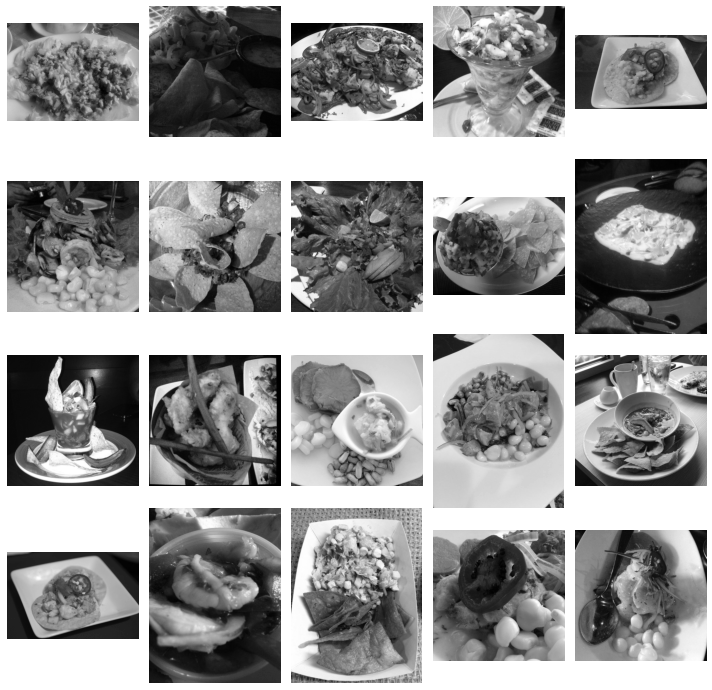

In [7]:
# Quick visual inspection here, unit tests performed for skimage functions in tests/test_preprocess.py
plot_img_grid(food = ceviche_g)

## 2. Rescale and Resize
Rescale and resizing the images simplifies the analysis further so that feature selection with PCA is consistent. First look at the frequency of each image size. 512x512 images represents just over half the sample followed by 384x512 and 512x384.

In [8]:
# Columns
cw = pp.pixel_dimensions(ceviche_g, dimension = 'width')
dw = pp.pixel_dimensions(donuts_g, dimension = 'width')

# Rows
ch = pp.pixel_dimensions(ceviche_g, dimension = 'height')
dh = pp.pixel_dimensions(donuts_g, dimension = 'height')

# View frequency table in descending order
pp.frequency_table(width_list = np.append(cw, dw),
                height_list = np.append(ch, dh))[0:5]

/usr/local/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


,width,height,freq
78,512,512,1176
30,384,512,313
65,512,384,136
63,512,382,62
28,382,512,60


Let's rescale the image to 1/5 of its original size and combine the datasets into a single dictionary. Looking at the frequency table, we can see the most frequent dimension in 102x102 pixels. 

In [9]:
# Rescale to 1/5 of size and combine into a dictionary
pp_data = dict()
rescale_d = [rescale(img, 0.2) for img in donuts_g]
rescale_c = [rescale(img, 0.2) for img in ceviche_g]

pp_data['data_rescaled'] = rescale_d + rescale_c
pp_data['labels'] = np.array(['donut' for img in donuts_g] + ['ceviche' for img in ceviche_g])

# Count the dimentions of each image after rescaling and view frequency table
rescaled_sizes = pp.frequency_table(width_list = pp.pixel_dimensions(pp_data['data_rescaled'], dimension = 'width'),
                                    height_list = pp.pixel_dimensions(pp_data['data_rescaled'], dimension = 'height'))[0:5]

rescaled_sizes

/usr/local/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


,width,height,freq
49,102,102,1195
17,77,102,324
40,102,77,141
39,102,76,63
16,76,102,62


Take the mean of the width and height then resize each image to be the same size. Images are now 92 x 92

In [10]:
avg_width = np.round(rescaled_sizes['width'].mean())
avg_height = np.round(rescaled_sizes['height'].mean())

pp_data['data_pp'] = np.array([resize(img, (avg_width, avg_height)).reshape(-1) for img in pp_data['data_rescaled']])

print(avg_width)
print(avg_height)

92.0
92.0


# 3) Feature engineering
1) Apply Principal Components Analysis (PCA) for feature selection

First split training and test data. Feature selection by PCA should be done after a train/test split since we don't want the algorithm to learn anything from the test set. Stratify sampling ensures that the labels are balanced in all sets - an assumption I make since the raw data is balanced between civeches and donuts.

A method to increase the sample size is to augment the dataset by rotating or reflecting the images of the training set. However I did not have time to implement this.

In [11]:
# Feature data. 2000 images, 8464 features (pixels)
X = pp_data['data_pp']
X.shape

(2000, 8464)

In [12]:
# Target
y = pp_data['labels']
y.shape

(2000,)

In [13]:
# Stratify ensures even split between donuts and caviche
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=40, stratify = y)

## 1. PCA
Apply PCA to the training data and visualise the cumulative variance explained by the componenets. 

90% of the variation is explained by the first  159  components


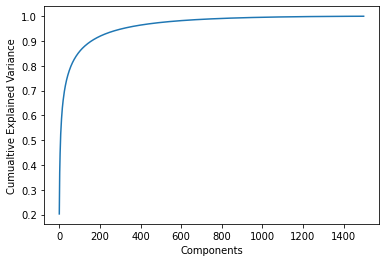

In [14]:
# 90% of the variation in the training data can be explained by the first 200 components
from sklearn.decomposition import PCA
pca = PCA().fit(Xtrain)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Cumualtive Explained Variance');

print('90% of the variation is explained by the first ', PCA(0.90, random_state = 40).fit(Xtrain).n_components_, ' components')

I arbitrarily choose the components which explain 85\% of the variation (the first 94 in this case). This will be used as an input into the modeling pipeline in the next section.

In [15]:
n_85 = PCA(0.85, random_state = 40).fit(Xtrain).n_components_
print(n_85)

94


# 4) Train Classification Model
The a variety of algorithms that can be used for a binary classification task. For this task, I choose an arbitrary pair of algorithms: SVM and random forests. Since the sample is small, I use k=3 folds cross validation to determine the most appropriate hyper parameters using a gridsearch for model tuning.

F1 score is used as the evaluation metric. Other target metrics can be used depending on the model use case and nature of the data. After fitting both Random Forests and SVM, I compare the compare the F1 scores of the best Random Forest and SVM models. I select the model with the best score to apply to the test set.

Note that for this challenge it is assumed that all data will always be either a donut or a ceviche. If there was any type of image as potential input, then the modeling task becomes a multi class classification. This would require images that are not donuts or ceviches as training and test data. 

In [16]:
def ml_pipeline(model, param_grid, xtrain, ytrain):
    '''
    Runs model fitting and cross validation for inputted algorithm
    '''
    
    # Instantiate PCA object and the evaluation metric. Let Donut be the "positive" label.
    pca = PCA(n_components = n_85, random_state = 40)
    f1_scorer = make_scorer(f1_score, pos_label="donut")
    
    algo = model
    pipeline = make_pipeline(pca, algo)
    
    grid = GridSearchCV(estimator = pipeline, 
                        param_grid = param_grid, 
                        cv = 3, 
                        scoring = f1_scorer)
    
    grid.fit(Xtrain, ytrain)
    
    return(grid)

In [17]:
# SVMs
sv_grid = ml_pipeline(model = SVC(),
                      param_grid = {'svc__C': [1, 5, 10, 50],
                                    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]},
                      xtrain = Xtrain,
                      ytrain = ytrain)

print(sv_grid.best_score_)

0.6533112783514948


In [18]:
# Random Forest
rf_grid = ml_pipeline(model = RandomForestClassifier(),
                      param_grid = {'randomforestclassifier__max_depth': [2,4,6,None],
                                    'randomforestclassifier__n_estimators': [50,100,150,200]},
                      xtrain = Xtrain,
                      ytrain = ytrain)

print(rf_grid.best_score_)

0.6175843147436796


The tuned SVM model has the best f1 metric. I will select this to be my classification model and fit this on the test data.

In [19]:
model = sv_grid.best_estimator_
print(model)
yfit = model.predict(Xtest)

Pipeline(steps=[('pca', PCA(n_components=94, random_state=40)),
                ('svc', SVC(C=1, gamma=0.005))])


# 5) Model performance

Next we view the evaluate the final performance of the best model on the test set. There are a variety of metrics that can be used to measure performance - the focus depends on the particular use case. For now we take a broad view of preformance and compare the precision, recall and f1 scores. We also look at the confusion matrix to see the raw counts  used to calculate these metrics.

Overall, the model performs better than a coin flip across all metrics.

In [20]:
print(classification_report(ytest, yfit))

              precision    recall  f1-score   support

     ceviche       0.62      0.63      0.63       250
       donut       0.62      0.61      0.62       250

    accuracy                           0.62       500
   macro avg       0.62      0.62      0.62       500
weighted avg       0.62      0.62      0.62       500



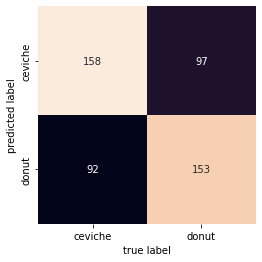

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest, yfit)

sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['ceviche', 'donut'],
            yticklabels=['ceviche', 'donut'])

plt.xlabel('true label')
plt.ylabel('predicted label');